In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict
from plot import *
import seaborn as sns

plt.style.use('seaborn-whitegrid')
logging.basicConfig(level=logging.CRITICAL)

/tmp/ipykernel_821484/1415743176.py:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
# choices = ["all_avg", "modular_ablation", "modular", "monolithic", "modmod_budget", "fedavg_monolithic_budget" "fedavg_modular_budget" "recv_modular" "recv_monolithic"
# "modmod_topology" "fedavg_modular_topology" "fedavg_monolithic_topology"]
what_to_plot = "fedavg_modular_topology"

In [4]:
# datasets = ["mnist", "kmnist", "fashionmnist", "combined", "cifar100"]
datasets = ["mnist", "kmnist", "fashionmnist"]
experiment_folder = "experiment_results"


use_contrastive = True

viz = False
seeds = [0, 1, 2, 3, 4, 5, 6, 7]
tasks=None
agent_ids = None
ax=None
sync_bases = [True]
opt_with_randoms = [False]

metric='test_acc'



num_tryout_epochs = 20
max_num_modules_tryout = 3
num_shared_module_list = [1,2,3,4]

fedavg_comm_freq = [5, 10, 20, 50, 100]

recv_num_queries = [10, 20, 30]
recv_comm_freq = [9, 16, 50]

def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    if "sync_base" not in cfg.sharing_strategy:
        cfg.sharing_strategy['sync_base'] = False
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

# algos = ['modular']
if what_to_plot == "all_avg":
    algos = ['monolithic', 'modular']
    mode = "avg"
elif "modular" in what_to_plot or "modmod" in what_to_plot:
    algos = ['modular']
    mode = "current"
elif "monolithic" in what_to_plot:
    algos = ['monolithic']
    mode = "avg"
else:
    raise ValueError("Invalid choice")

use_contrastive_list = [False]


freeze_candidate_module = False
no_sparse_basis_ls = [True]

if what_to_plot == "modular_ablation":
    transfer_decoder_ls = [True, False]
    transfer_structure_ls = [True, False]
else:
    transfer_decoder_ls = [True]
    transfer_structure_ls = [True]

In [5]:
def get_save_dirs_modmod(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for sync_base in sync_bases:
        for opt_with_random in opt_with_randoms:
            for use_contrastive_opt in use_contrastive_list:
                for transfer_decoder in transfer_decoder_ls:
                    for transfer_structure in transfer_structure_ls:
                        for no_sparse_basis in no_sparse_basis_ls:
                            if dataset == "combined":
                                experiment_name = f"leep_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                            else:
                               experiment_name = f"jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                            name = f'jorge_setting_lowest_id_sync_{sync_base}_rand_{opt_with_random}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}'
                            if use_contrastive_opt:
                                name += "_contrastive"
                            save_dirs[name] = get_save_dir(experiment_folder, experiment_name,
                                                    dataset, "modular", num_trains_per_class, use_contrastive_opt, seed)

    return save_dirs



def get_save_dirs_modmod_budget(dataset, seed, budget_experiment_folder=None):
    if budget_experiment_folder is None:
        budget_experiment_folder = experiment_folder

    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for num_shared_module in num_shared_module_list:
        for sync_base in sync_bases:
            for opt_with_random in opt_with_randoms:
                for use_contrastive_opt in use_contrastive_list:
                    for transfer_decoder in transfer_decoder_ls:
                        for transfer_structure in transfer_structure_ls:
                            for no_sparse_basis in no_sparse_basis_ls:
                                if dataset == "combined":
                                    experiment_name = f"leep_tryout_epochs_{num_tryout_epochs}_max_modules_{max_num_modules_tryout}_num_shared_modules_{num_shared_module}_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                                else:
                                    experiment_name = f"tryout_epochs_{num_tryout_epochs}_max_modules_{max_num_modules_tryout}_num_shared_modules_{num_shared_module}_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                                name = f"tryout_epochs_{num_tryout_epochs}_max_modules_{max_num_modules_tryout}_num_shared_modules_{num_shared_module}_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                                if use_contrastive_opt:
                                    name += "_contrastive"
                                save_dirs[name] = get_save_dir(budget_experiment_folder, experiment_name,
                                                        dataset, "modular", num_trains_per_class, use_contrastive_opt, seed)

    return save_dirs


def get_save_dirs_recv(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    experiment_name = f"jorge_setting_recv"
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            name = f"recv_{algo}"
            save_dirs[name] = get_save_dir(experiment_folder, experiment_name,
                                                dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs
    

def get_save_dirs_base(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            for no_sparse_basis in no_sparse_basis_ls:
                if no_sparse_basis:
                    base_experiment_name = "vanilla_jorge_setting_basis_no_sparse"
                else:
                    base_experiment_name = "vanilla_jorge_setting"
                name = f'{algo}_no_sparse_basis_{no_sparse_basis}'
                if use_contrastive_opt:
                    name += "_contrastive"
                save_dirs[name] = get_save_dir(experiment_folder, base_experiment_name,
                                        dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs

def get_save_dirs_fedavg(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            name = f'fedavg_{algo}'
            save_dirs[name] = get_save_dir(experiment_folder, "jorge_setting_fedavg",
                                            dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs


def get_save_dirs_fedavg_budget(dataset, seed, budget_experiment_folder=None):
    if budget_experiment_folder is None:
        budget_experiment_folder = experiment_folder
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            for freq in fedavg_comm_freq:
                name = f'fedavg_{algo}_f_{freq}'
                save_dirs[name] = get_save_dir(budget_experiment_folder, f"comm_freq_{freq}",
                                                dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs

def get_save_dirs_recv_budget(dataset, seed, budget_experiment_folder=None):
    if budget_experiment_folder is None:
        budget_experiment_folder = experiment_folder
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            for num_queries in recv_num_queries:
                for freq in recv_comm_freq:
                    name = f'recv_{algo}_nq_{num_queries}_f_{freq}'
                    # list all folder in budget_experiment_results that has the pattern "*comm_freq_{freq}_num_queries_{num_queries}*"
                    for folder in os.listdir(budget_experiment_folder):
                        if f"comm_freq_{freq}_num_queries_{num_queries}" in folder:
                            save_dirs[name] = get_save_dir(budget_experiment_folder, folder,
                                                dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs



def get_save_dirs_modmod_topology(dataset, seed, topology_experiment_results=None):
    if topology_experiment_results is None:
        topology_experiment_results = experiment_folder
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            # list all folder in budget_experiment_results that has the pattern "*comm_freq_{freq}_num_queries_{num_queries}*"
            for folder in os.listdir(topology_experiment_results):
                if not os.path.isdir(os.path.join(topology_experiment_results, folder)):
                    continue
                save_dirs[folder] = get_save_dir(topology_experiment_results, folder,
                                    dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs


def get_save_dirs(dataset, seed):
    save_dirs = {}

    if what_to_plot == "all_avg" or what_to_plot == "modular" or what_to_plot == "monolithic":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        if "modular" in algos:
            save_dirs.update(get_save_dirs_modmod(dataset, seed))
        save_dirs.update(get_save_dirs_fedavg(dataset, seed))
        save_dirs.update(get_save_dirs_recv(dataset, seed))
    elif what_to_plot == "modular_ablation":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_modmod(dataset, seed))
    elif what_to_plot == "modmod_budget":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_modmod_budget(dataset, seed, budget_experiment_folder="budget_experiment_results/modmod"))
    elif "fedavg" in what_to_plot and "topology" in what_to_plot:
        save_dirs.update(get_save_dirs_fedavg(dataset, seed))
        save_dirs.update(get_save_dirs_modmod_topology(dataset, seed, topology_experiment_results="topology_experiment_results/topology_experiment_results/jorge_setting_fedavg/comm_freq_5"))

    elif "fedavg" in what_to_plot:
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_fedavg_budget(dataset, seed, budget_experiment_folder="budget_experiment_results/jorge_setting_fedavg"))
    elif "recv" in what_to_plot:
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_recv_budget(dataset, seed, budget_experiment_folder="budget_experiment_results/jorge_setting_recv_variable_shared_memory_size"))
    elif what_to_plot == "modmod_topology":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_modmod(dataset, seed))
        save_dirs.update(get_save_dirs_modmod_topology(dataset, seed, topology_experiment_results="topology_experiment_results/modmod"))
    else:
        raise ValueError("Invalid choice")
    return save_dirs

In [6]:
remap_name = {"modular_no_sparse_basis_True" : "modular (baseline)",
              "monolithic_no_sparse_basis_True": "monolithic (baseline)",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_False_no_sparse_basis_True": "transfer modules",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_True_no_sparse_basis_True": "transfer modules + structure",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True": "modmod",

            #  "jorge_setting_lowest_id_sync_False_rand_False_transfer_decoder_False_transfer_structure_False_no_sparse_basis_True": "transfer modules (no sync)",
            # "jorge_setting_lowest_id_sync_False_rand_False_transfer_decoder_False_transfer_structure_True_no_sparse_basis_True": "transfer modules + structure (no sync)",
            #  "jorge_setting_lowest_id_sync_False_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True": "transfer modules + structure + decoder (no sync)",

             "recv_modular": "Recv Modular",
             "fedavg_modular": "FedAvg Modular",
             "recv_monolithic": "Recv Monolithic",
            "fedavg_monolithic": "FedAvg Monolithic",

            'tryout_epochs_20_max_modules_3_num_shared_modules_1_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=1)',
            'tryout_epochs_20_max_modules_3_num_shared_modules_2_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=2)',
            'tryout_epochs_20_max_modules_3_num_shared_modules_3_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=3)',
            'tryout_epochs_20_max_modules_3_num_shared_modules_4_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=4)',

            'fedavg_monolithic_f_5': 'FedAvg Monolithic (f=5)',
            'fedavg_monolithic_f_10': 'FedAvg Monolithic (f=10)',
            'fedavg_monolithic_f_20': 'FedAvg Monolithic (f=20)',
            'fedavg_monolithic_f_50': 'FedAvg Monolithic (f=50)',
            'fedavg_monolithic_f_100': 'FedAvg Monolithic (f=100)',

            'fedavg_modular_f_5': 'FedAvg Modular (f=5)',
            'fedavg_modular_f_10': 'FedAvg Modular (f=10)',
            'fedavg_modular_f_20': 'FedAvg Modular (f=20)',
            'fedavg_modular_f_50': 'FedAvg Modular (f=50)',
            'fedavg_modular_f_100': 'FedAvg Modular (f=100)',

            'recv_monolithic_nq_10_f_9': 'Recv Monolithic (nq=10, f=9)',
            'recv_monolithic_nq_10_f_16': 'Recv Monolithic (nq=10, f=16)',
            'recv_monolithic_nq_10_f_50': 'Recv Monolithic (nq=10, f=50)',
            'recv_monolithic_nq_20_f_9': 'Recv Monolithic (nq=20, f=9)',
            'recv_monolithic_nq_20_f_16': 'Recv Monolithic (nq=20, f=16)',
            'recv_monolithic_nq_20_f_50': 'Recv Monolithic (nq=20, f=50)',
            'recv_monolithic_nq_30_f_9': 'Recv Monolithic (nq=30, f=9)',
            'recv_monolithic_nq_30_f_16': 'Recv Monolithic (nq=30, f=16)',
            'recv_monolithic_nq_30_f_50': 'Recv Monolithic (nq=30, f=50)',

            'recv_modular_nq_10_f_9': 'Recv Modular (nq=10, f=9)',
            'recv_modular_nq_10_f_16': 'Recv Modular (nq=10, f=16)',
            'recv_modular_nq_10_f_50': 'Recv Modular (nq=10, f=50)',
            'recv_modular_nq_20_f_9': 'Recv Modular (nq=20, f=9)',
            'recv_modular_nq_20_f_16': 'Recv Modular (nq=20, f=16)',
            'recv_modular_nq_20_f_50': 'Recv Modular (nq=20, f=50)',
            'recv_modular_nq_30_f_9': 'Recv Modular (nq=30, f=9)',
            'recv_modular_nq_30_f_16': 'Recv Modular (nq=30, f=16)',
            'recv_modular_nq_30_f_50': 'Recv Modular (nq=30, f=50)',

            'topology_server_edge_drop_0.0': 'server',
            'topology_tree_edge_drop_0.0': 'tree',
            'topology_ring_edge_drop_0.0': 'ring',

            'topology_random_edge_drop_0.7': 'random (p=0.7)',
            'topology_random_edge_drop_0.5': 'random (p=0.5)',
            'topology_random_edge_drop_0.25': 'random (p=0.25)',
            'topology_random_edge_drop_0.9': 'random (p=0.9)',
             }

num_colors = len(remap_name)
color_map = plt.cm.get_cmap('tab20b', num_colors)
colors = color_map(range(num_colors))

# colormap = {
#     'modular (baseline)': colors[0],
#     "monolithic (baseline)": colors[1],
#     'modmod': colors[2],
#     'Recv Modular': colors[3],
#     'FedAvg Modular': colors[4],
#     'Recv Monolithic': colors[5],
#     'FedAvg Monolithic': colors[6],
#     'transfer modules': colors[7],
#     'transfer modules + structure': colors[8],
#     'modmod (k=1)': colors[9],
#     'modmod (k=2)': colors[10],
#     'modmod (k=3)': colors[11],
#     'modmod (k=4)': colors[12],


# }

colormap = {k: colors[i] for i, k in enumerate(remap_name.values())}


/tmp/ipykernel_821484/432108784.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20b', num_colors)


In [7]:
dataset_seed_aucs, dataset_agg_dfs = load_data(get_save_dirs, seeds, datasets, modify_cfg, viz, tasks, agent_ids, ax, mode=mode,
                                               metric=metric, strict=True)

In [8]:
# HACK: for fedavg just throw away the epoch 5 since it's not recorded in the later code for some reasons
if what_to_plot == "fedavg_monolithic_topology":
    dataset_agg_dfs = {k: df[df['epoch'] != 5] for k, df in dataset_agg_dfs.items()}

In [9]:
df = dataset_agg_dfs['mnist']
# df
# df[df['name'] == 'fedavg_monolithic']
df[df['name'] == 'topology_random_edge_drop_0.25']

,epoch,test_acc_mean,test_acc_std,count,seed,name
0,0,0.506456,0.062519,48,0,topology_random_edge_drop_0.25
1,1,0.498754,0.027228,48,0,topology_random_edge_drop_0.25
2,11,0.572049,0.133167,48,0,topology_random_edge_drop_0.25
3,21,0.641786,0.156697,48,0,topology_random_edge_drop_0.25
4,31,0.692948,0.167267,48,0,topology_random_edge_drop_0.25
...,...,...,...,...,...,...
7,61,0.657493,0.171092,48,7,topology_random_edge_drop_0.25
8,71,0.705979,0.164929,48,7,topology_random_edge_drop_0.25
9,81,0.744799,0.151573,48,7,topology_random_edge_drop_0.25
10,91,0.780013,0.137670,48,7,topology_random_edge_drop_0.25


In [10]:
dataset_agg_dfs['mnist'].name.unique()

array(['fedavg_modular', 'topology_random_edge_drop_0.7',
       'topology_server_edge_drop_0.0', 'topology_random_edge_drop_0.5',
       'topology_random_edge_drop_0.9', 'topology_ring_edge_drop_0.0',
       'topology_tree_edge_drop_0.0', 'topology_random_edge_drop_0.25'],
      dtype=object)

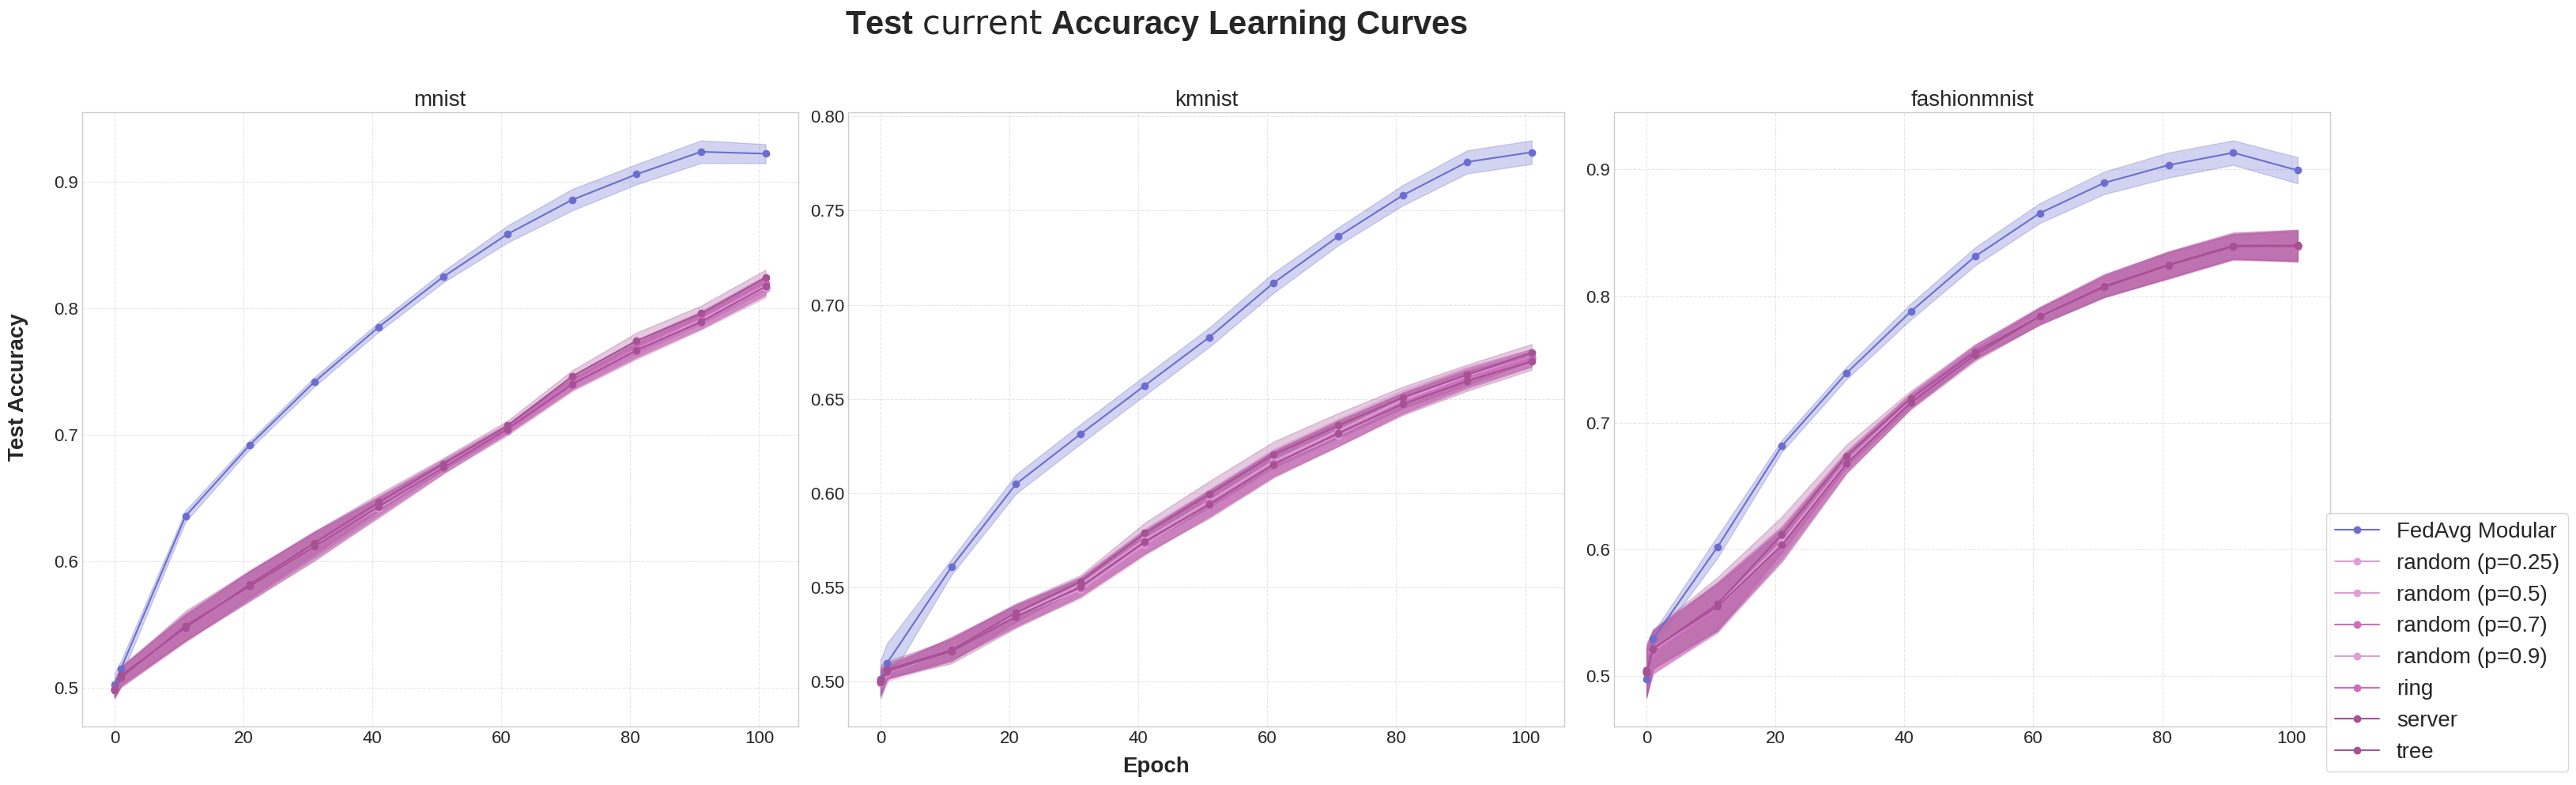

In [11]:
plot_learning_curve_dataset(dataset_agg_dfs, remap_name=remap_name, colormap=colormap,
                            mode=mode, save_fig_path=f'Figures/{what_to_plot}_lc.pdf')

fedavg_modular: Average AUC = 80.22, STD = 2.20, STDERR = 0.78
topology_random_edge_drop_0.7: Average AUC = 67.65, STD = 3.92, STDERR = 1.38
topology_server_edge_drop_0.0: Average AUC = 68.08, STD = 3.56, STDERR = 1.26
topology_random_edge_drop_0.5: Average AUC = 67.81, STD = 3.77, STDERR = 1.33
topology_random_edge_drop_0.9: Average AUC = 67.76, STD = 3.92, STDERR = 1.39
topology_ring_edge_drop_0.0: Average AUC = 67.85, STD = 3.66, STDERR = 1.29
topology_tree_edge_drop_0.0: Average AUC = 67.72, STD = 3.89, STDERR = 1.38
topology_random_edge_drop_0.25: Average AUC = 67.74, STD = 3.83, STDERR = 1.35
fedavg_modular: Average AUC = 68.14, STD = 2.16, STDERR = 0.76
topology_random_edge_drop_0.7: Average AUC = 59.64, STD = 2.27, STDERR = 0.80
topology_server_edge_drop_0.0: Average AUC = 59.95, STD = 1.96, STDERR = 0.69
topology_random_edge_drop_0.5: Average AUC = 59.67, STD = 2.27, STDERR = 0.80
topology_random_edge_drop_0.9: Average AUC = 59.75, STD = 2.15, STDERR = 0.76
topology_ring_edge_

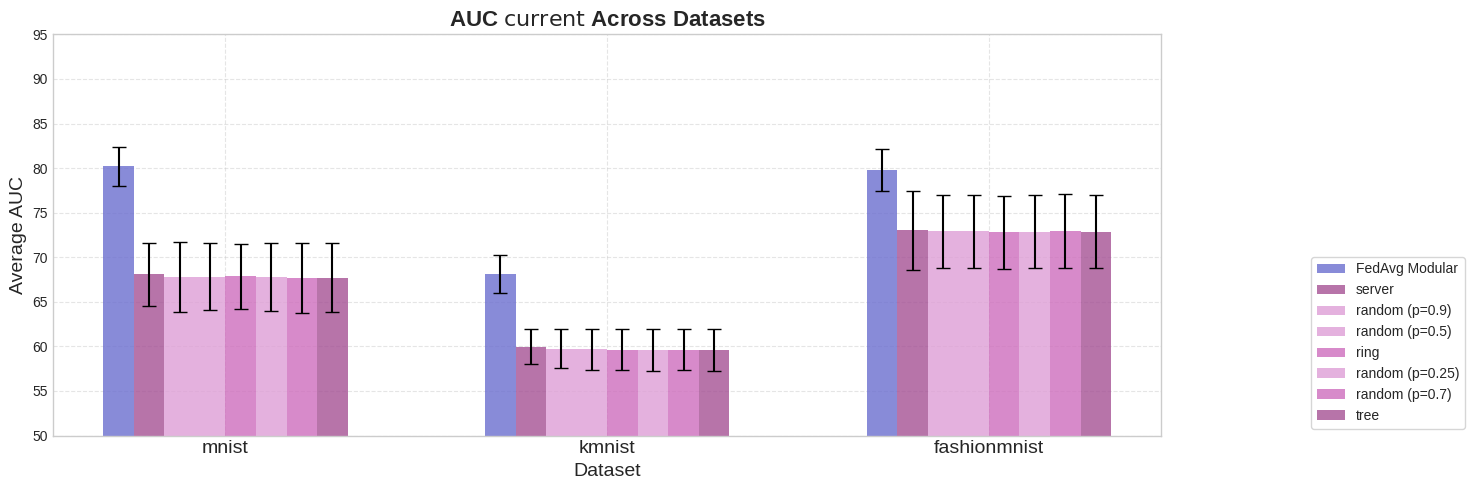

In [12]:
plot_auc_combined(dataset_seed_aucs, remap_name=remap_name, colormap=colormap, mode=mode, save_fig_path=f'Figures/{what_to_plot}_auc.pdf',
                  bar_width=0.08)